# Project 12: Bot Playing "Dixit" Board Game

An agent capable of playing "Dixit" may be created by combining a CLIP-like model for image understanding with a large language model (LLM) for generating and interpreting creative descriptions. We want an agent capable of playing both roles in Dixit: who guesses and who gives the hint.

In this project, you will:
- Develop a bot to play Dixit, based
on a pre-trained CLIP-like model to
interpret images and a LLM to
generate descriptions (GPT APIs
are fine).
- Conduct experiments to compare the bot's performance against GPT-4o multimodal and
humans in >10 games.

Hashtags: #generative-AI, #multimodal-models

<br>

---

<br>

### Outline:

0. Literature review: spend a paragraph about how CLIP can be used for this problem. As a matter of fact, it can't really give us exactly what we want and creative captioning is currently an open research field itself. Some words about CLIP and how it works, VIT (visual transformer models) and possible strategies to implement the storyteller (the most difficult part):
  - Use CLIP + LLM (gonna need a vocabulary of fantasy keywords or some other sort of input text)
  - Use BLIP for the storyteller to generate image captions and CLIP for the guesser to match image and description similarity
  - Use YOLO/SAM/other models for image segmentation + LLM to generate a complete caption for the storyteller and CLIP for the guesser
  **Keep in mind:** Dixit descriptions are short, usually just a word or two. Maybe incorporate this constraint in the prompt to the LLM, or anyway check its feasibility.
1. Utility functions
2. Import images
3. Role 1: the storyteller. Select an image and generate a creative, concise description for it. <br>
   Image $\to$ Text
4. Role 2: the guesser. Given an image description and a batch of candidate images, try to guess which image belongs to the storyteller. <br>
A possible way to implement this is to generate descriptions for all the images of interest and compute some kind of similarity score with respect to the one provided by the storyteller. Finally, select the image with the most similar description as the guess. <br>
   Text $\gets\to$ Text   
5. [*BONUS*]
   - Test different CLIP models! Maybe then compare performances
   - Implement the cards selection and points assignment mechanisms, creating a raw but real demo of the game
   - Use a parameter to set the level of "creativity" allowed in the description(s)
   - Make it a game that can be played cpu VS user, in a simplified 1-vs-1 mode

<br>

---

<br>

### Start experimenting

#### Images

How does Dixit work?

**Game set-up:** shuffle the cards and give 6 of them to each player. The cards dealt should not be seen by other players. Make a draw pile with the remaining cards. The players then take the following roles.

**The storyteller:** one player is the storyteller for the turn. He makes up a short sentence (even just a word) for one of the cards in his hand and says it out loud, without showing the chosen card. Then, the other players select amongst their images the one that best matches the definition given by the storyteller and put it covered at the center of the table, where they get shuffled.

**The guesser:** the goal of each other player is to find the storyteller's original card among the ones revealed in each turn. They have to guess, one at a time, and secretly vote for the card that they think matches best the definition. Once everyone has voted, the guesses are revealed and the storyteller indicates his/her original card. Based on how many players put their bet on which card, points are assigned and players advance on the scoreboard.

(for now, we'll ignore the voting tokens and the points mechanism)

In [2]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

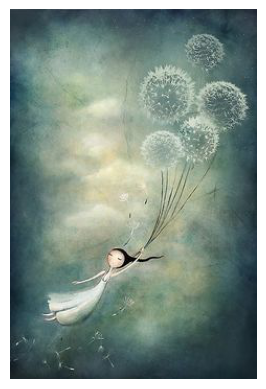

In [3]:
fig = plt.figure()
img = imread(".\cards\card_00001.jpg")
plt.imshow(img);
plt.axis('off');

In [4]:
def plot_random_images(folder = ".\cards", n = 4, seed = None):
 
    '''
    Function that displays n images chosen at random from the specified folder.
    '''

    # Open the folder and handle errors
    try:
        image_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    except FileNotFoundError:
        print(f"[ERROR]: folder '{folder}' not found!")
        return

    if not image_list: # use lists' implicit booleanness
        print(f"[WARNING]: the folder '{folder}' is empty.")
        return
    num_images = min(n, len(image_list))

    if seed:
        random.seed(seed)
    random_images = random.sample(image_list, num_images)

    # Plot
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize = (15, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            img_path = os.path.join(folder, random_images[i])
            img = imread(img_path)
            ax.imshow(img)
            ax.set_title(random_images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    fig.suptitle('Some random images', fontsize = 20)
    plt.tight_layout()
    plt.show()
    return

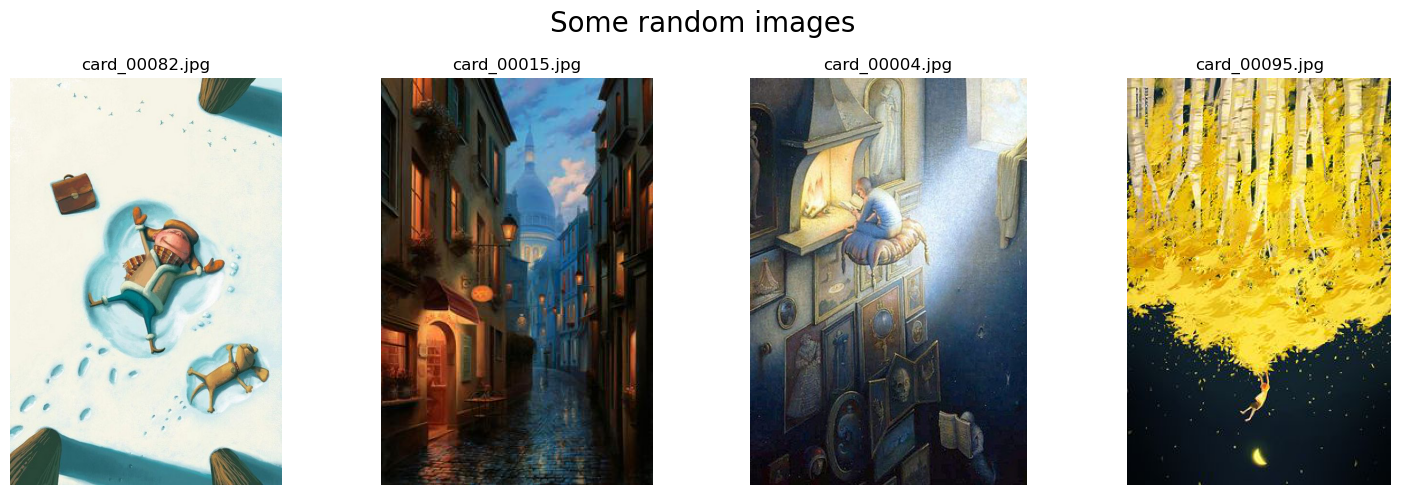

In [5]:
plot_random_images(seed = 42)

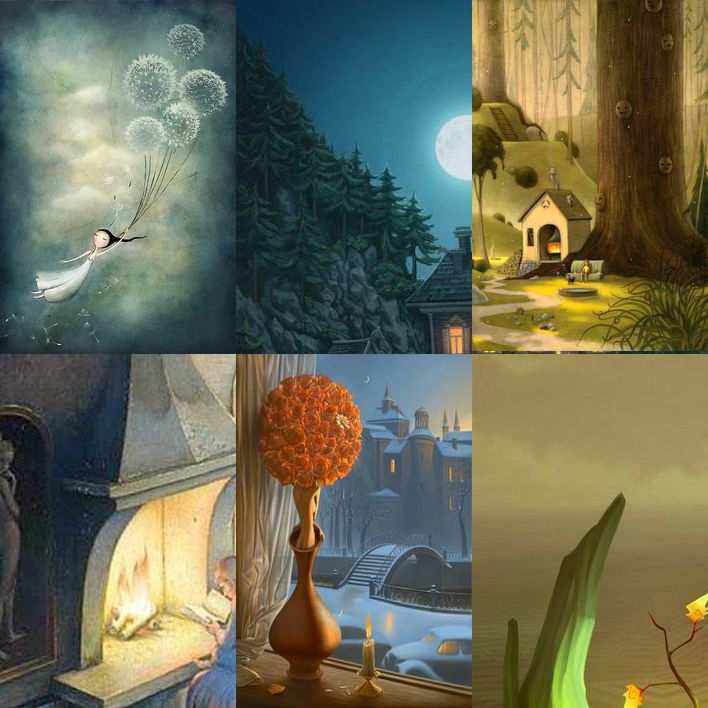

In [6]:
# Va bene usare PIL e Image, ma aggiusta le dimensioni
from PIL import Image

def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size = (cols * w, rows * h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box = (i % cols * w, i // cols * h))
    return grid

folder = ".\cards"
image_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
images = []

for url in image_list:
    images.append(Image.open('./cards/' + url))

grid = image_grid(images[:6], cols = 3)
display(grid)

$\textcolor{red}{!}$ (The dimensions are wrong, remember to debug it)

#### CLIP (Contrastive Language-Image Pre-Training)

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.

https://github.com/openai/CLIP

CLIP is a neural network trained on a variety of image and text pairs. It essentially creates a shared embedding space for images and text, meaning that you could use it to find the most relevant caption (given a selection of captions) for a given image, or vice-versa find the most relevant image for a given text snippet. An important thing to note is that CLIP is not a generative model, i.e. it does not generate the text-snippet or image, you use the embedding space to retrieve a previously embedded item.

https://medium.com/@kerry.halupka/getting-started-with-openais-clip-a3b8f5277867

In [ ]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")            # CLIP model 
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")    # CLIP processor

In [2]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [3]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, sp

- Model: it probably comes as no surprise that this is the CLIP model. What might interest you more though is that under the hood it’s actually two models! This is because CLIP uses a ViT-like transformer to get visual features and a causal language model to get the text features, this class wraps up both of these pieces.
- Processor: The CLIPProcessor also wraps up two pieces: the CLIPFeatureExtractor to prepare the images for the image network, and the CLIPTokenizer, which encodes text ready for the language model.
- Both Model and Processor require a config to be specified (I’ve specified openai/clip-vit-base-patch32 , which uses a ViT-B/32 Transformer architecture as an image encoder and, a masked self-attention Transformer as a text encoder). You need to use the same config string for both, otherwise you won’t have a good time.

- It's easy to test out other model configs, just search on HuggingFace

In [5]:
import torch
print(torch.__version__)

1.13.1+cpu


In [1]:
# Using directly Github's implemenatation
#! pip install torchvision
#! pip install ftfy regex tqdm
#! pip install git+https://github.com/openai/CLIP.git

# Using Huggingface's transformers
#! pip install torch==2.2
#! python -m venv .env
#! .env/Scripts/activate
#! pip install transformers